## Rarefaction Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import comb

RNG = np.random.default_rng(42)


In [2]:
# Load transect and occurrence data
# Paths assume notebook resides in notebooks/ directory
transects_path = '../data/pkl/df_transects.pkl'
occurrences_path = '../data/pkl/df_occurrences_with_taxon.pkl'

try:
    df_transects = pd.read_pickle(transects_path)
    df_occurrences = pd.read_pickle(occurrences_path)
except FileNotFoundError as e:
    raise FileNotFoundError(f"Required data file missing: {e}")

# Filter transects: exclude 2008 and 2024 except 'shrubs closed'; only old reserve

df_transects['Year'] = pd.to_datetime(df_transects['start_time']).dt.year
mask_not_2008 = df_transects['Year'] != 2008
mask_keep_2024 = ~((df_transects['Year'] == 2024) & (df_transects['Pre: Transect physical habitat'] != 'shrubs closed'))
df_filtered_transects = df_transects[mask_not_2008 & mask_keep_2024].copy()
df_filtered_transects = df_filtered_transects[df_filtered_transects['Pre: On old reserve?'] == 'Yes'].copy()

rename_transects = {'UID': 'TransectID', 'Pre: Transect physical habitat': 'Habitat'}
df_filtered_transects = df_filtered_transects.rename(columns=rename_transects)

# Prepare occurrences
rename_occ = {'UID': 'TransectID', 'Taxon Label': 'Taxon'}
df_occurrences = df_occurrences.rename(columns=rename_occ)
df_occurrences = df_occurrences[df_occurrences['TransectID'].isin(df_filtered_transects['TransectID'])]

excluded_species = ['ostrich', 'Aves (medium)', 'Aves (small)']
df_occurrences = df_occurrences[~df_occurrences['Taxon'].isin(excluded_species)]

df_occurrences = df_occurrences.merge(
    df_filtered_transects[['TransectID', 'Habitat']],
    on='TransectID',
    how='left'
)

habitats = sorted(df_occurrences['Habitat'].dropna().unique())
print('Habitats:', habitats)


Habitats: ['grass closed', 'shrubs closed', 'shrubs open', 'trees closed']


In [3]:
def build_incidence_matrix(df, habitat):
    subset = df[df['Habitat'] == habitat]
    matrix = (subset
              .pivot_table(index='TransectID', columns='Taxon', aggfunc='size', fill_value=0)
              .astype(int))
    return matrix


def sample_coverage(counts):
    t = counts.sum()
    if t == 0:
        return 0.0
    freq = (counts > 0).sum(axis=0)
    Q1 = (freq == 1).sum()
    Q2 = (freq == 2).sum()
    if t == 1:
        return 1 - Q1 / t
    return 1 - (Q1 / t) * ((t - 1) * Q1 / ((t - 1) * Q1 + 2 * Q2))


def accumulate(matrix, max_samples=None, n_iter=200, extrapolate=0):
    n_transects = matrix.shape[0]
    species = matrix.shape[1]
    if max_samples is None:
        max_samples = n_transects + extrapolate
    richness = np.zeros((n_iter, max_samples), dtype=float)
    coverage = np.zeros((n_iter, max_samples), dtype=float)
    ids = matrix.index.to_numpy()
    data = matrix.to_numpy()
    for i in range(n_iter):
        order = RNG.permutation(n_transects)
        for k in range(max_samples):
            if k < n_transects:
                sample = data[order[:k+1]]
            else:
                extra = RNG.choice(n_transects, size=k+1-n_transects, replace=True)
                sample = np.vstack([data[order], data[extra]])
            counts = (sample.sum(axis=0) > 0).astype(int)
            richness[i, k] = counts.sum()
            coverage[i, k] = sample_coverage(sample)
    mean_r = richness.mean(axis=0)
    ci_r = np.percentile(richness, [2.5, 97.5], axis=0)
    mean_c = coverage.mean(axis=0)
    ci_c = np.percentile(coverage, [2.5, 97.5], axis=0)
    return mean_r, ci_r, mean_c, ci_c


def chao2_incidence(mat):
    inc = (mat > 0).sum(axis=0)
    Sobs = (inc > 0).sum()
    Q1 = (inc == 1).sum()
    Q2 = (inc == 2).sum()
    return Sobs + (Q1 * Q1) / (2 * Q2) if Q2 > 0 else Sobs + (Q1 * (Q1 - 1)) / (2 * (Q2 + 1))


def chao2_bootstrap(mat, n_boot=200):
    est = chao2_incidence(mat)
    boots = np.empty(n_boot)
    for i in range(n_boot):
        sample = mat.sample(n=mat.shape[0], replace=True)
        boots[i] = chao2_incidence(sample)
    lo_p, hi_p = np.percentile(boots, [2.5, 97.5])
    ci_percentile = (lo_p, hi_p)
    ci_basic = (2 * est - hi_p, 2 * est - lo_p)
    bias = boots.mean() - est
    return est, np.array(ci_percentile), np.array(ci_basic), bias, boots


In [4]:
results = []
all_curves = {}
boots_by_hab = {}
for hab in habitats:
    mat = build_incidence_matrix(df_occurrences, hab)
    mean_r, ci_r, mean_c, ci_c = accumulate(mat, max_samples=mat.shape[0]*2)
    est, ci_p, ci_b, bias, boots = chao2_bootstrap(mat)
    boots_by_hab[hab] = boots
    all_curves[hab] = {
        'mean_r': mean_r,
        'ci_r': ci_r,
        'mean_c': mean_c,
        'ci_c': ci_c,
        'chao2': est,
        'chao_ci_percentile': ci_p,
        'chao_ci_basic': ci_b,
        'bias': bias,
        'n_transects': mat.shape[0]
    }
    results.append({
        'Habitat': hab,
        'Chao2': est,
        'Bias': bias,
        'Chao2_lower_basic': ci_b[0],
        'Chao2_upper_basic': ci_b[1],
        'Chao2_lower_percentile': ci_p[0],
        'Chao2_upper_percentile': ci_p[1]
    })

summary_df = pd.DataFrame(results)
summary_df


/tmp/ipykernel_7851/2708850226.py:18: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - (Q1 / t) * ((t - 1) * Q1 / ((t - 1) * Q1 + 2 * Q2))
/tmp/ipykernel_7851/2708850226.py:18: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - (Q1 / t) * ((t - 1) * Q1 / ((t - 1) * Q1 + 2 * Q2))
/tmp/ipykernel_7851/2708850226.py:18: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - (Q1 / t) * ((t - 1) * Q1 / ((t - 1) * Q1 + 2 * Q2))


,Habitat,Chao2,Bias,Chao2_lower_basic,Chao2_upper_basic,Chao2_lower_percentile,Chao2_upper_percentile
0,grass closed,19.0,-1.536125,13.0000,25.0000,13.0000,25.0000
1,shrubs closed,15.0,-1.662042,12.5000,20.0000,10.0000,17.5000
2,shrubs open,21.0,-3.487208,14.9875,28.8375,13.1625,27.0125
3,trees closed,29.0,-16.876667,35.4750,52.0000,6.0000,22.5250


In [5]:
# QC: recompute Chao2 directly from matrices
qc_records = []
for hab in habitats:
    mat = build_incidence_matrix(df_occurrences, hab)
    direct = chao2_incidence(mat)
    table_val = summary_df.loc[summary_df['Habitat']==hab, 'Chao2'].iloc[0]
    qc_records.append({'Habitat': hab, 'DirectChao2': direct, 'TableChao2': table_val})
pd.DataFrame(qc_records)


,Habitat,DirectChao2,TableChao2
0,grass closed,19.0,19.0
1,shrubs closed,15.0,15.0
2,shrubs open,21.0,21.0
3,trees closed,29.0,29.0


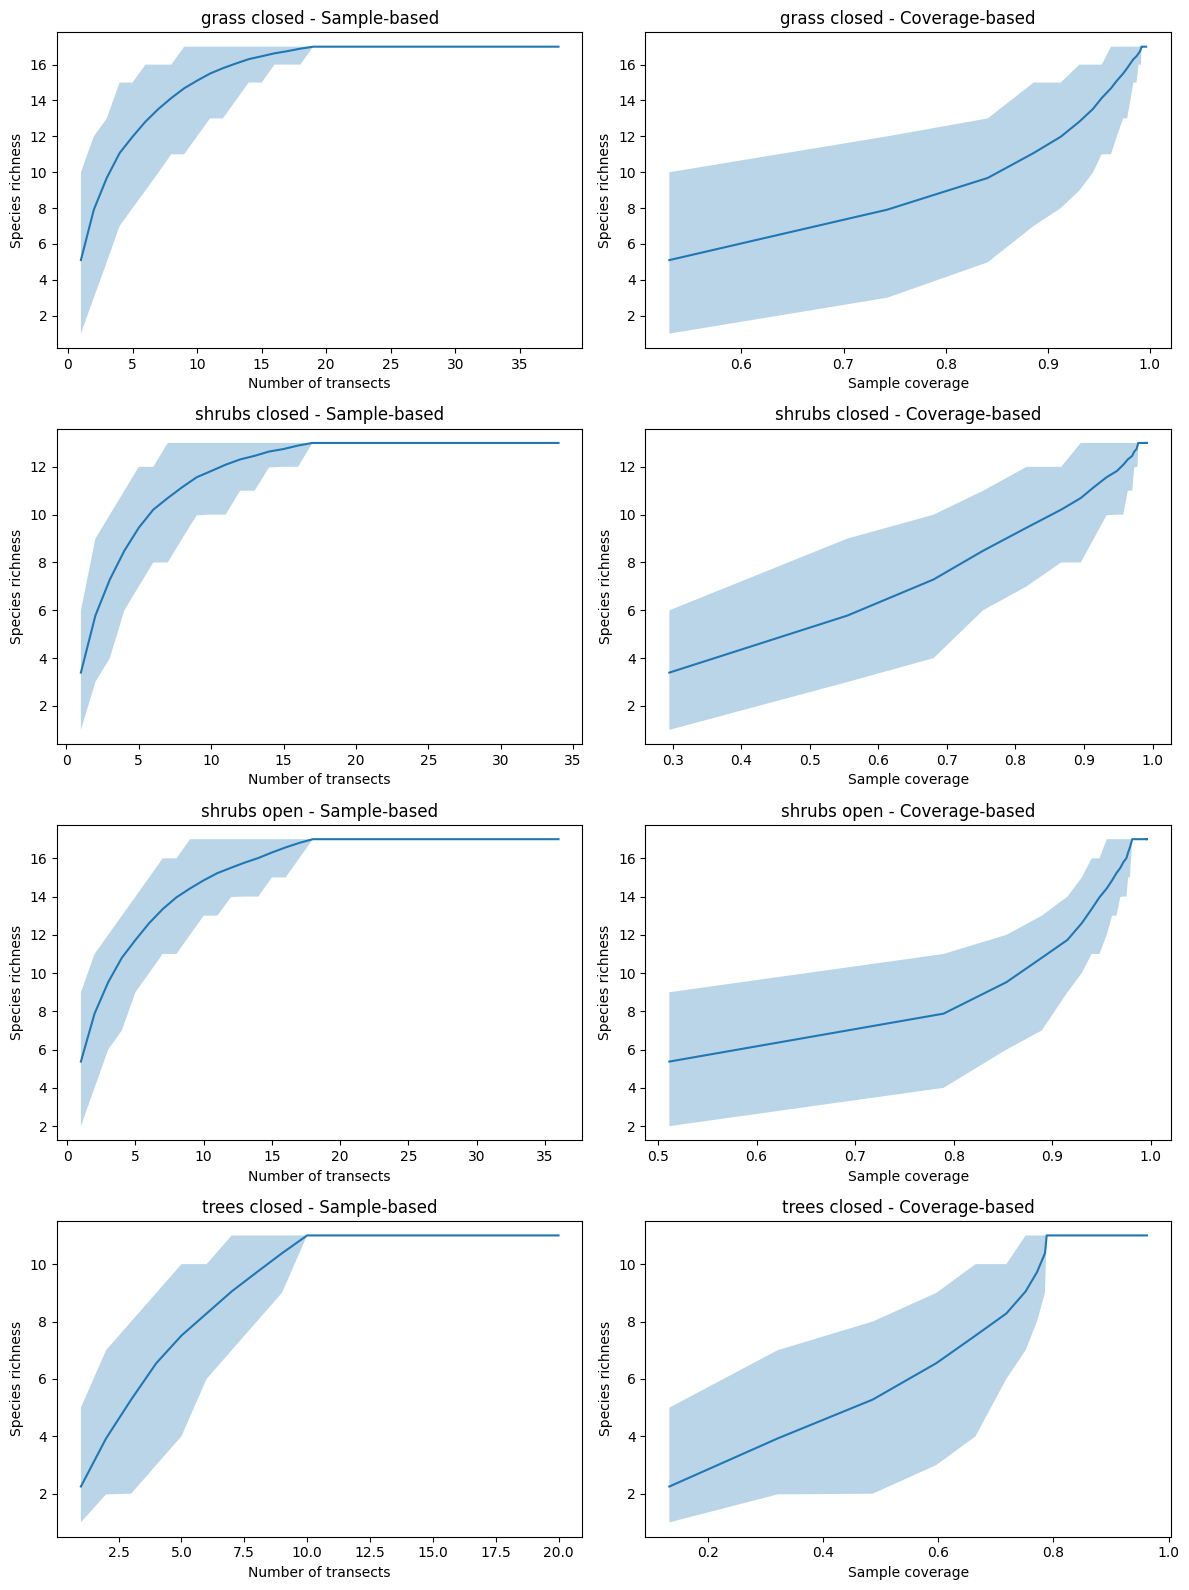

In [6]:
# Sample-based accumulation plots
fig, axes = plt.subplots(len(habitats), 2, figsize=(12, 4 * len(habitats)))
for i, hab in enumerate(habitats):
    curves = all_curves[hab]
    # Accumulation
    ax = axes[i,0] if len(habitats) > 1 else axes[0]
    x = np.arange(1, len(curves['mean_r']) + 1)
    ax.plot(x, curves['mean_r'], label='Mean richness')
    ax.fill_between(x, curves['ci_r'][0], curves['ci_r'][1], alpha=0.3)
    ax.set_title(f'{hab} - Sample-based')
    ax.set_xlabel('Number of transects')
    ax.set_ylabel('Species richness')
    # Coverage-based
    ax2 = axes[i,1] if len(habitats) > 1 else axes[1]
    ax2.plot(curves['mean_c'], curves['mean_r'])
    ax2.fill_between(curves['mean_c'], curves['ci_r'][0], curves['ci_r'][1], alpha=0.3)
    ax2.set_title(f'{hab} - Coverage-based')
    ax2.set_xlabel('Sample coverage')
    ax2.set_ylabel('Species richness')
plt.tight_layout()
plt.show()


In [7]:
# Richness at equal effort (10 transects) and equal coverage (95%)
records = []
for hab in habitats:
    curves = all_curves[hab]
    x = np.arange(1, len(curves['mean_r']) + 1)
    # Equal effort
    k = min(10, curves['n_transects'])
    richness_k = curves['mean_r'][k-1]
    # Equal coverage
    target_cov = 0.95
    cov = curves['mean_c']
    if (cov >= target_cov).any():
        idx = np.argmax(cov >= target_cov)
        richness_cov = curves['mean_r'][idx]
    else:
        richness_cov = np.nan
    records.append({'Habitat': hab, 'Richness@10': richness_k, 'Richness@95%cov': richness_cov})
richness_df = pd.DataFrame(records)
richness_df


,Habitat,Richness@10,Richness@95%cov
0,grass closed,15.105,14.135
1,shrubs closed,11.825,12.090
2,shrubs open,14.850,14.425
3,trees closed,11.000,11.000


Curves are based on incidence (presence/absence). Detectability likely varies among habitats, so coverage-based comparisons complement equal-effort curves.